In [3]:
import geopandas as gpd
import pandas as pd
import pysal
import pickle
%matplotlib inline

In [4]:
def crs_prepossess(gpdf, bfr_crs, init_crs=4326):
    """
    create a shallow copy of gpdf; check the init crs of gpdf, if None, assign init_crs; change crs of copy to bfr_crs
    :param gpdf: geopandas.GeoDataFrame
    :param init_crs: init_crs epsg code
    :param bfr_crs: target crs epsg code used for buffering
    :return: a shallow copy of gpdf in bfr_crs
    """
    gpdf_crs = gpdf.copy()
    if gpdf_crs.crs == None:
        gpdf_crs.crs = {'init': u'epsg:{}'.format(init_crs)}
    return gpdf_crs.to_crs(epsg=bfr_crs)

In [5]:
def find_col_type(column):
    for t, array in cols_by_type.items():
        if column in array:
            return t
    return 'None'

In [6]:

cols_by_type=pickle.load(open('data/x_NO_TOTAL_~2014_cols_by_type.pkl' , 'rb'))

seg = gpd.read_file('d:/★★学习工作/Life in Maryland/Research Project：CyclingSafe/Cycling_safety/open_data_analysis/data/segments_dc.geojson')
csl = pd.read_csv('data/y_csl_all-2017-10-01.csv',index_col=0)
x = pd.read_csv('data/x_NO_TOTAL_~2014.csv',index_col=0)
x_total = pd.read_csv('data/x_TOTAL_~2014.csv', index_col=0)
csl.index.name = 'index'
x.index.name = 'index'
x_total.index.name = 'index'

In [7]:
geom_seg = crs_prepossess(seg[['geometry']], 3559)

In [8]:
ks = [1,2,3,4,5,6,7,8, 9, 10]
ws_knn = {k: pysal.weights.KNN.from_dataframe(geom_seg[['geometry']], k=k) for k in ks}

In [9]:
dbs = [10, 50, 100, 150, 200, 300, 400]
ws_db_notbinary = {db: pysal.weights.DistanceBand.from_dataframe(geom_seg[['geometry']], threshold=db, binary=False, silent=True) for db in dbs}
ws_db_binary = {db: pysal.weights.DistanceBand.from_dataframe(geom_seg[['geometry']], threshold=db, binary=True, silent=True) for db in dbs}

D:\ProgramFiles\Anaconda3\lib\site-packages\scipy\sparse\data.py:103: RuntimeWarning: divide by zero encountered in reciprocal
  return self._with_data(data ** n)


In [10]:
islands = [ws_db_notbinary[db].islands.__len__() for db in dbs]
pd.DataFrame(list(zip(dbs, islands)), columns=['band', 'num_islands']).set_index('band').T

band,10,50,100,150,200,300,400
num_islands,13469,10234,1436,211,79,21,11


In [11]:
def compute_moran_i(ws, param_list, x, pname):
    res = []

    for i, cname in enumerate(x):
        if i % 40 == 0:
            print('i=', i, cname)
            
        data = x[cname]
        for p in param_list:
            w = ws[p]
            mi = pysal.Moran(data, w, two_tailed=True, permutations=999)
            res.append({
                'column':cname, 
                pname:p,
                'I': mi.I, 
                'EI': mi.EI, 
                'p_norm': mi.p_norm * 2,
                'p_rand': mi.p_rand * 2,
                'p_sim': mi.p_sim * 2, 
                'p_z_sim': mi.p_z_sim * 2,
                'z_norm': mi.z_norm,
                'z_rand': mi.z_rand,
            })
    print('done computing', pname)
    df = pd.DataFrame(res)
    return df[['column', pname, 'I', 'EI', 'p_norm', 'p_rand', 'z_norm', 'z_rand', 'p_sim', 'p_z_sim']]

In [12]:
# df_knn = compute_moran_i(ws_knn, ks, x, 'knn')
# df_db_notbinary = compute_moran_i(ws_db_notbinary, dbs, x, 'db_nb')
# df_db_binary = compute_moran_i(ws_db_binary, dbs, x, 'db_b')

In [13]:
# df_knn.to_csv('spatial-corr/moran-i-knn.csv')
# df_db_notbinary.to_csv('spatial-corr/moran-i-distanceband-not-binary.csv')
# df_db_binary.to_csv('spatial-corr/moran-i-distanceband-binary.csv')

In [14]:
df_knn = pd.read_csv('spatial-corr/moran-i-knn.csv', index_col=0)
df_db_notbinary = pd.read_csv('spatial-corr/moran-i-distanceband-not-binary.csv', index_col=0)
df_db_binary = pd.read_csv('spatial-corr/moran-i-distanceband-binary.csv', index_col=0)

In [15]:
# df_knn_total = compute_moran_i(ws_knn, ks, x_total, 'knn')
# df_db_notbinary_total = compute_moran_i(ws_db_notbinary, dbs, x_total, 'db_nb')
# df_db_binary_total = compute_moran_i(ws_db_binary, dbs, x_total, 'db_b')

In [16]:
# df_knn_total.to_csv('spatial-corr/moran-i-knn-total.csv')
# df_db_notbinary_total.to_csv('spatial-corr/moran-i-distanceband-not-binary-total.csv')
# df_db_binary_total.to_csv('spatial-corr/moran-i-distanceband-binary-total.csv')

In [17]:
df_knn_total = pd.read_csv('spatial-corr/moran-i-knn-total.csv', index_col=0)
df_db_notbinary_total = pd.read_csv('spatial-corr/moran-i-distanceband-not-binary-total.csv', index_col=0)
df_db_binary_total = pd.read_csv('spatial-corr/moran-i-distanceband-binary-total.csv', index_col=0)

## largest i per group

In [21]:
def largest_i_per_group(df):
    return df.sort_values(by='I', ascending=False)[:1]

In [29]:
def get_largest_i(df):
    largesI = df[df.p_norm<0.05].groupby('column').apply(largest_i_per_group)
    largesI['ftr_type'] = largesI.column.apply(find_col_type)
    return largesI.sort_values('I', ascending=False)


In [49]:
df_knn_largest_I = get_largest_i(df_knn)
df_db_binary_largest_I = get_largest_i(df_db_binary)
df_db_notbinary_largest_I = get_largest_i(df_db_notbinary)

In [50]:
df_knn_largest_I.drop(['p_sim','p_z_sim','EI'], axis=1).to_csv('spatial-corr/features-morani-knn.csv')
df_db_binary_largest_I.drop(['p_sim','p_z_sim','EI'], axis=1).to_csv('spatial-corr/features-morani-distband-binary.csv')
df_db_notbinary_largest_I.drop(['p_sim','p_z_sim','EI'], axis=1).to_csv('spatial-corr/features-morani-distband-not-binary.csv')

(204, 11)


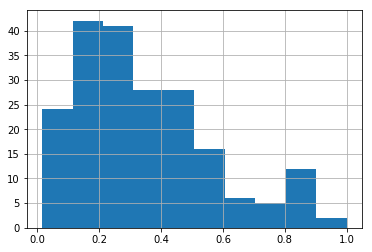

In [44]:

print(df_knn_largest_I.shape)
df_knn_largest_I.I.hist()

(204, 11)


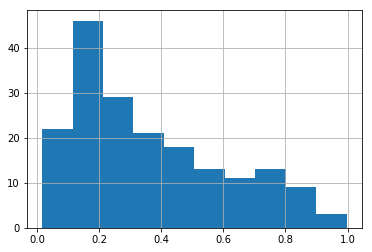

In [56]:
df = df_db_notbinary_largest_I
print(df.shape)
df[df.I<=1].I.hist()

## which w has most sig 

In [18]:
print(x.shape)

(13522, 231)


In [19]:
def most_sig(df):
    return((df.p_rand<0.001).sum())
    
df_knn.groupby('knn').apply(most_sig)

knn
1     197
2     199
3     202
4     202
5     203
6     203
7     203
8     203
9     204
10    204
dtype: int64

In [20]:
df_db_binary.groupby('db_b').apply(most_sig)

db_b
10      28
50     155
100    200
150    204
200    204
300    203
400    203
dtype: int64

In [21]:
print(x_total.shape)
df_db_binary_total.groupby('db_b').apply(most_sig)

(13522, 66)


db_b
10     16
50     54
100    64
150    64
200    64
300    64
400    64
dtype: int64

## features based on Autocorrelation

### for by type

In [23]:
i_thres=0


In [24]:
db_150 = df_db_binary.db_b==150
sig_rand = df_db_binary.p_rand<0.05
sig_cols = df_db_binary[db_150 & sig_rand].column.tolist()

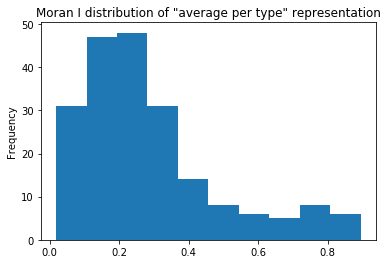

In [37]:
df_db_binary[db_150 & sig_rand].I.plot(kind='hist',title='Moran I distribution of "average per type" representation')

In [25]:
ws_db_binary[150].neighbors[0]

array([  16, 2818, 2819, 2820, 3267, 5786, 5787], dtype=int32)

In [58]:
res = {}
for col in sig_cols:
    column = x[col]
    new_col = {}
    for i, neighbor in ws_db_binary[150].neighbors.items():
        new_col[i] = column[neighbor].mean()
        res[col+'_neighbor'] = new_col


In [59]:
x_neighbor = pd.DataFrame(res)

In [61]:
# x_neighbor.to_csv('spatial-corr/x-neighbor-db-150-binary.csv')

In [34]:
x_neighbor = pd.read_csv('spatial-corr/x-neighbor-db-150-binary.csv', index_col=0)

In [39]:
for i_thres in [0, 0.1, 0.3, 0.5, 0.7, 0.8, 0.9]:
    pass_i_thres = df_db_binary.I.abs()>=i_thres
    keep_cols = df_db_binary[db_150 & sig_rand & pass_i_thres].column
    keep_cols = (keep_cols+'_neighbor').tolist()
#     x_neighbor[keep_cols].to_csv('spatial-corr/x-neighbor-db-150-binary-i-%0.1f.csv' % i_thres)
    print(i_thres, len(keep_cols))

0 204
0.1 176
0.3 69
0.5 29
0.7 14
0.8 7
0.9 0


### for total

In [41]:
db_150_total = df_db_binary_total.db_b==150
sig_rand_total = df_db_binary_total.p_rand<0.05
sig_cols_total = df_db_binary_total[db_150_total & sig_rand_total].column.tolist()

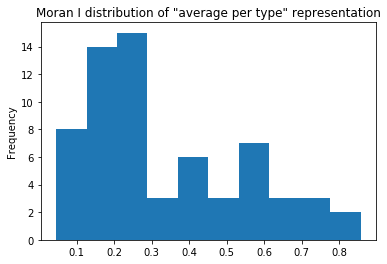

In [43]:
df_db_binary_total[db_150_total & sig_rand_total].I.plot(kind='hist',title='Moran I distribution of "average across type" representation')

In [75]:
res_total = {}
for col in sig_cols_total:
    column = x_total[col]
    new_col = {}
    for i, neighbor in ws_db_binary[150].neighbors.items():
        new_col[i] = column[neighbor].mean()
        res_total[col+'_neighbor'] = new_col


In [76]:
x_neighbor_total = pd.DataFrame(res_total)

In [89]:
x_neighbor_total.to_csv('spatial-corr/x_total-neighbor-db-150-binary.csv')

In [81]:
x_total['crime_total'][ws_db_binary[150].neighbors[10]].mean()

148.42857142857142

In [84]:
x_neighbor_total['crime_total_neighbor'][10]

148.42857142857142

In [64]:
x_neighbor['SHAPE_Length_neighbor']

0        104.658886
1        139.736116
2        124.670219
3        144.087532
4        131.400003
5        121.677280
6        129.971130
7        140.609054
8        122.961322
9        101.207537
10        96.456270
11        84.854613
12        85.740517
13       134.345257
14        93.040086
15        84.969293
16       150.405056
17       144.965182
18       165.464633
19       164.031447
20       109.636242
21       107.265854
22        81.292169
23        84.939074
24        90.660515
25       136.729714
26       132.765079
27       108.702887
28       117.201217
29       127.698943
            ...    
13492     49.598000
13493     93.324704
13494     74.333905
13495     74.726887
13496     24.402475
13497     85.331897
13498     75.976080
13499     75.714933
13500    128.262553
13501           NaN
13502     54.883443
13503     75.922190
13504     75.515839
13505     75.515839
13506    378.387636
13507     64.619689
13508      0.000000
13509     76.847104
13510     61.949539


In [52]:
x_neighbor_total = pd.read_csv('spatial-corr/x_total-neighbor-db-150-binary.csv', index_col=0)

In [44]:
for i_thres_total in [0, 0.1, 0.3, 0.5, 0.7, 0.8, 0.9]:
    pass_i_thres_total = df_db_binary_total.I.abs()>=i_thres_total
    keep_cols_total = df_db_binary_total[db_150_total & sig_rand_total & pass_i_thres_total].column
    keep_cols_total = (keep_cols_total+'_neighbor').tolist()
#     x_neighbor_total[keep_cols_total].to_csv('spatial-corr/x_total-neighbor-db-150-binary-i-%0.1f.csv' % i_thres_total)
    print(i_thres_total, len(keep_cols_total))

0 64
0.1 60
0.3 27
0.5 16
0.7 5
0.8 2
0.9 0


# Moran for CSL

In [109]:
seg_csl = csl.join(geom_seg).reset_index()

y = seg_csl.csl

In [110]:
seg_csl

,index,csl,geometry
0,97,3.354839,LINESTRING (398596.2266464538 136323.170924826...
1,98,3.466667,LINESTRING (398596.2016429628 136476.912831046...
2,101,2.636364,LINESTRING (398594.2058833765 136882.818725917...
3,102,3.073171,LINESTRING (398594.7340700076 136925.870609674...
4,103,2.686275,LINESTRING (398596.8716300512 137053.344448108...
5,104,4.200000,LINESTRING (398596.6816270133 137185.944475026...
6,126,3.000000,LINESTRING (398357.2342854695 136329.369920676...
7,127,3.395062,LINESTRING (398358.0230948051 136476.494388065...
8,128,3.476190,LINESTRING (398357.7917167192 136610.684352811...
9,131,1.000000,LINESTRING (398358.0315822557 137031.104438184...


In [151]:
def y_knn_moran():
    res = []
    for k in [1,2,3,4,5,6,7,8, 9, 10]:
        w = pysal.weights.KNN.from_dataframe(seg_csl[['geometry']], k=k)
        mi = pysal.Moran(y,w,two_tailed=True, permutations=999)
        res.append((k, mi.I, mi.EI, mi.p_norm, mi.p_rand, mi.p_sim, mi.p_z_sim, mi.z_norm, mi.z_rand))
    y_df_knn = pd.DataFrame(res)
    y_df_knn.columns = ['k', 'I', 'EI', 'p_norm', 'p_rand', 'p_sim', 'p_z_sim', 'z_norm', 'z_rand']
    y_df_knn.set_index('k',inplace=True)
    return y_df_knn

In [154]:
y_df_knn=y_knn_moran()
y_df_knn.to_csv('spatial-corr/moran-i-y-knn.csv')
y_df_knn

,I,EI,p_norm,p_rand,p_sim,p_z_sim,z_norm,z_rand
k,,,,,,,,
1,0.553485,-0.002227,0.0,0.0,0.001,0.0,9.580850,11.697648
2,0.554943,-0.002227,0.0,0.0,0.001,0.0,12.453631,15.196297
3,0.510821,-0.002227,0.0,0.0,0.001,0.0,14.013379,17.083941
4,0.456902,-0.002227,0.0,0.0,0.001,0.0,14.500473,17.661231
5,0.407120,-0.002227,0.0,0.0,0.001,0.0,14.451868,17.585877
6,0.369557,-0.002227,0.0,0.0,0.001,0.0,14.398179,17.503944
7,0.340758,-0.002227,0.0,0.0,0.001,0.0,14.417794,17.510164
8,0.319585,-0.002227,0.0,0.0,0.001,0.0,14.493063,17.584380
9,0.293606,-0.002227,0.0,0.0,0.001,0.0,14.141535,17.141381


In [137]:
seg_csl.shape[0]

450

In [164]:
def y_db_moran(y, seg_csl, binary=False):
    res = []
    for d in dbs:
        w = pysal.weights.DistanceBand.from_dataframe(seg_csl, threshold=d, binary=binary, silent=True)
        mi = pysal.Moran(y,w,two_tailed=True, permutations=999)
        res.append((d, mi.I, mi.EI, mi.p_norm, mi.p_rand, mi.p_sim, mi.p_z_sim, mi.z_norm, mi.z_rand, len(w.islands)/seg_csl.shape[0]))
    df = pd.DataFrame(res)
    df.columns = ['db', 'I', 'EI', 'p_norm', 'p_rand', 'p_sim', 'p_z_sim', 'z_norm', 'z_rand', 'pcnt_islands']
    return df

In [165]:
y_df_db_binary = y_db_moran(y, seg_csl, True)

D:\ProgramFiles\Anaconda3\lib\site-packages\pysal\esda\moran.py:188: RuntimeWarning: invalid value encountered in double_scalars
  self.VI_norm = v_num / v_den - (1.0 / (n - 1)) ** 2
D:\ProgramFiles\Anaconda3\lib\site-packages\pysal\esda\moran.py:192: RuntimeWarning: divide by zero encountered in double_scalars
  vi = (1 / (((n - 1) ** 3) * s02)) * ((n * ((n * n - 3 * n + 3)
D:\ProgramFiles\Anaconda3\lib\site-packages\pysal\esda\moran.py:195: RuntimeWarning: invalid value encountered in double_scalars
  s2 + 6 * s02)))
D:\ProgramFiles\Anaconda3\lib\site-packages\pysal\esda\moran.py:202: RuntimeWarning: divide by zero encountered in double_scalars
  return self.n / self.w.s0 * inum / self.z2ss
D:\ProgramFiles\Anaconda3\lib\site-packages\pysal\esda\moran.py:202: RuntimeWarning: invalid value encountered in double_scalars
  return self.n / self.w.s0 * inum / self.z2ss
D:\ProgramFiles\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encoun

In [166]:
y_df_db_binary.to_csv('spatial-corr/moran-i-y-distanceband-binary.csv')
y_df_db_binary

,db,I,EI,p_norm,p_rand,p_sim,p_z_sim,z_norm,z_rand,pcnt_islands
0,10,NaN,-0.002227,NaN,NaN,0.001,NaN,NaN,NaN,1.000000
1,50,0.906813,-0.002227,0.000001,2.983049e-09,0.001,5.621375e-07,4.858226,5.932528,0.886667
2,100,0.562882,-0.002227,0.000000,0.000000e+00,0.001,0.000000e+00,9.155715,11.175891,0.295556
3,150,0.515658,-0.002227,0.000000,0.000000e+00,0.001,0.000000e+00,12.149401,14.820376,0.055556
4,200,0.453124,-0.002227,0.000000,0.000000e+00,0.001,0.000000e+00,13.078427,15.938740,0.024444
5,300,0.357936,-0.002227,0.000000,0.000000e+00,0.001,0.000000e+00,14.231467,17.297475,0.008889
6,400,0.236543,-0.002227,0.000000,0.000000e+00,0.001,0.000000e+00,11.844820,14.349943,0.002222


In [167]:
y_df_db_nonbinary = y_db_moran(y, seg_csl, False)

D:\ProgramFiles\Anaconda3\lib\site-packages\scipy\sparse\data.py:103: RuntimeWarning: divide by zero encountered in reciprocal
  return self._with_data(data ** n)
D:\ProgramFiles\Anaconda3\lib\site-packages\pysal\esda\moran.py:188: RuntimeWarning: invalid value encountered in double_scalars
  self.VI_norm = v_num / v_den - (1.0 / (n - 1)) ** 2
D:\ProgramFiles\Anaconda3\lib\site-packages\pysal\esda\moran.py:192: RuntimeWarning: divide by zero encountered in double_scalars
  vi = (1 / (((n - 1) ** 3) * s02)) * ((n * ((n * n - 3 * n + 3)
D:\ProgramFiles\Anaconda3\lib\site-packages\pysal\esda\moran.py:195: RuntimeWarning: invalid value encountered in double_scalars
  s2 + 6 * s02)))
D:\ProgramFiles\Anaconda3\lib\site-packages\pysal\esda\moran.py:202: RuntimeWarning: divide by zero encountered in double_scalars
  return self.n / self.w.s0 * inum / self.z2ss
D:\ProgramFiles\Anaconda3\lib\site-packages\pysal\esda\moran.py:202: RuntimeWarning: invalid value encountered in double_scalars
  retu

In [168]:
y_df_db_nonbinary.to_csv('spatial-corr/moran-i-y-distanceband-non-binary.csv')
y_df_db_nonbinary

,db,I,EI,p_norm,p_rand,p_sim,p_z_sim,z_norm,z_rand,pcnt_islands
0,10,NaN,-0.002227,NaN,NaN,0.001,NaN,NaN,NaN,1.000000
1,50,0.900155,-0.002227,0.000001,4.187048e-09,0.001,0.000003,4.812432,5.876629,0.886667
2,100,0.565565,-0.002227,0.000000,0.000000e+00,0.001,0.000000,9.143949,11.161680,0.295556
3,150,0.527431,-0.002227,0.000000,0.000000e+00,0.001,0.000000,12.151339,14.824157,0.055556
4,200,0.486102,-0.002227,0.000000,0.000000e+00,0.001,0.000000,13.408815,16.345801,0.024444
5,300,0.418000,-0.002227,0.000000,0.000000e+00,0.001,0.000000,15.023114,18.279101,0.008889
6,400,0.327735,-0.002227,0.000000,0.000000e+00,0.001,0.000000,14.179222,17.216955,0.002222
